## Momentum Trading Strategy based on Section 2.2.2 of Quantitative Portfolio Management
### Imports, tickers, and data downloads. Convert to log returns

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from time import sleep
import os.path

In [2]:
stocks_tickers = pd.read_csv("liquid_us_stocks.csv")
ticker_company_dict = {key: value for key,value in zip(stocks_tickers["Ticker"],stocks_tickers["Company Name"])}

In [3]:
stocks_tickers = stocks_tickers[["Ticker"]]

In [4]:
stocks_tickers.head()

,Ticker
0,JPM
1,BAC
2,WFC
3,C
4,GS


In [5]:
stocks_tickers = stocks_tickers["Ticker"].tolist()

In [6]:
def batch_download_data(tickers, period, batch_size=5):
    all_data = pd.DataFrame()

    for i in range(0, len(tickers), batch_size):
        batch_tickers = tickers[i:i+batch_size]
        print(f"Downloading data for {batch_tickers}")
        
        batch_data = yf.download(batch_tickers, period=period, auto_adjust=True)["Close"]
        if isinstance(batch_data, pd.Series):
            batch_data = batch_data.to_frame()

        na_count = batch_data.isna().sum().sum()
        print(f"Downloaded data for {batch_tickers} with NA count: {na_count}")
        
        all_data = pd.concat([all_data, batch_data], axis=1)
        sleep(30)

    return all_data


period = "1y"

if os.path.exists('stock_data.pkl'):
    stock_data = pd.read_pickle("stock_data.pkl")
else:
    downloaded_data = batch_download_data(stocks_tickers, period, 5)
    downloaded_data.to_pickle("stock_data.pkl")
    print("Finished downloading data")
    downloaded_data.to_pickle("stock_data.pkl")

In [7]:
stock_data = pd.read_pickle("stock_data.pkl")

In [8]:
stock_log_returns_data = np.log(stock_data/stock_data.shift(1))

In [9]:
print(stock_log_returns_data.isna().sum().sum())

48


In [10]:
stock_log_returns_data = stock_log_returns_data.dropna()

## Creating the momentum signal
- For each stock *s* on day *d*, compute past *k*-day returns (7 day returns)
- Rank stocks by past return
- Go long (1) top decile, and short (-1) bottom decile

In [11]:
def momentum_signal(df, k):
    k_day_returns = np.exp(df.rolling(window=k).sum())-1

    signal_returns = k_day_returns.shift(1)

    signal_returns = signal_returns.dropna()

    daily_ranks = signal_returns.rank(axis=1, method='first',ascending=False)
    
    n_stocks = signal_returns.shape[1]

    top_n = int(n_stocks*0.1)
    bottom_n = int(n_stocks*0.1)

    signals = pd.DataFrame(np.where(daily_ranks <= top_n, 1, np.where(daily_ranks > n_stocks - bottom_n, -1, 0)), index=signal_returns.index, columns=signal_returns.columns)

    return signals

In [12]:
signals = momentum_signal(stock_log_returns_data, 21)

In [13]:
signals.head()

Ticker,BAC,C,GS,JPM,WFC,BMY,JNJ,MRK,MS,PFE,...,CVS,DIS,DOW,GE,HON,LMT,MMM,DUK,NEE,SO
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-06,0,0,0,0,0,0,0,0,0,0,...,1,-1,0,0,0,0,0,0,1,0
2024-06-07,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2024-06-10,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2024-06-11,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2024-06-12,0,0,0,0,-1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## Simple backtest

In [14]:
portfolio_returns = []
capital = 100000
cash = capital
positions = {}
portfolio_returns = []
previous_portfolio_value = capital

common_dates = signals.index.intersection(stock_data.index)
signals = signals.loc[common_dates]
stock_prices = stock_data.loc[common_dates]
stock_log_returns = stock_log_returns_data.loc[common_dates]

In [15]:
for date, daily_signals in signals.iterrows():
    if daily_signals.isna().all():
        portfolio_returns.append(0)
        continue

    daily_returns = stock_log_returns_data.loc[date]
    daily_portfolio_return = 0

    for ticker in list(positions.keys()):
        price = stock_prices.loc[date, ticker]
        if positions[ticker] > 0:  # Close long
            cash += positions[ticker] * price
        else:  # Close short
            cash -= abs(positions[ticker]) * price
        del positions[ticker]

    long_signals = daily_signals[daily_signals == 1].index
    short_signals = daily_signals[daily_signals == -1].index
    num_long = len(long_signals)
    num_short = len(short_signals)
    total_signals = num_long + num_short

    if total_signals > 0:
        capital_per_position = capital / total_signals

        # Open long positions
        for ticker in long_signals:
            price = stock_prices.loc[date, ticker]
            num_shares = capital_per_position / price 
            if num_shares > 0:
                positions[ticker] = num_shares
                cash -= num_shares * price
            daily_portfolio_return += positions.get(ticker, 0) * daily_returns[ticker]

        # Open short positions
        for ticker in short_signals:
            price = stock_prices.loc[date, ticker]
            num_shares = capital_per_position / price
            if num_shares > 0:
                positions[ticker] = -num_shares
                cash += num_shares * price
            daily_portfolio_return += positions.get(ticker, 0) * daily_returns[ticker]

    # Calculate portfolio value and daily return
    portfolio_value = cash + sum(positions.get(ticker, 0) * stock_prices.loc[date, ticker] for ticker in positions)
    daily_return = (portfolio_value - previous_portfolio_value) / previous_portfolio_value
    portfolio_returns.append(daily_return)
    previous_portfolio_value = portfolio_value

In [16]:
portfolio_returns_df = pd.DataFrame(portfolio_returns, columns=["PortfolioReturn"], index=signals.index)
portfolio_returns_df['Cumulative Return'] = (1 + portfolio_returns_df['PortfolioReturn']).cumprod() - 1

sharpe = (portfolio_returns_df['PortfolioReturn'].mean() * np.sqrt(252)) / portfolio_returns_df['PortfolioReturn'].std()

print(f"Final Portfolio Value: {portfolio_value}")
print(f"Annualised Sharpe Ratio: {sharpe}")

Final Portfolio Value: 84078.71636321551
Annualised Sharpe Ratio: -0.9688726213775346


<Axes: title={'center': 'Cumulative Portfolio Return'}, xlabel='Date'>

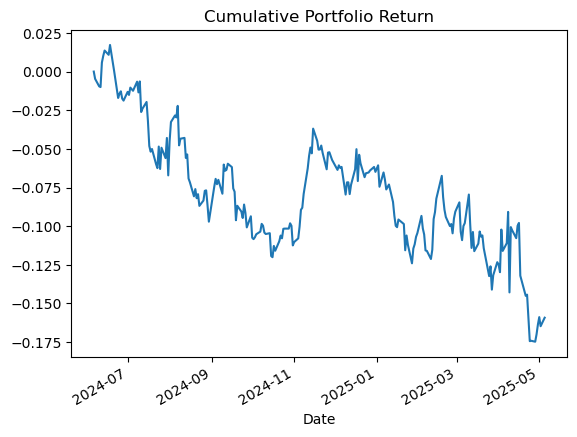

In [17]:
portfolio_returns_df["Cumulative Return"].plot(title="Cumulative Portfolio Return")